## CA1
Reza Abdoli 810100251

## Goal
In this CA we learn how to use, implement and solve knapsack problem using Genetic algorithm which ordinary search algorithms are not efficient

## Problem Description
in this problem we are given several snacks with their weight and values and we have to pick a good combination of the snacks considering the conditions below:
- the total value of the snacks we pick must be above a certain value
- the total weight of the snacks we take with us must be less than a certain weight
- the number of types of food that we choose must be within a certain range
- the selected weight of each snack must not exceed the available weight of that food 

## Input
Inputs are given to the program in the form of a CSV file.

# Consts and Libraries
## 1 : possibility for each item of selection (mutation , crossover, reproduction)
    - UNIFORM CROSSOVER RATE is for the probability of a bit change in the parent chromosome
## 2 :  
    - NUMBER_OF_GENERATIONS indicates that the algorithm will continue for several generations
    - INITIAL_POPULATION is the fist generation

## 3 : inputs of the program

In [202]:
import random
import pandas as pd
import matplotlib.pyplot as plt
# ------------------------------------------ 1
REPRODUCTION_RATE = 0.35
CROSSOVER_RATE = 0.5
UNIFORM_CROSSOVER_RATE = 0.5
MUTATION_RATE = 0.015
# ------------------------------------------ 2
NUMBER_OF_GENERATIONS = 4
INITIAL_POPULATION = 20
# 4 gen + 20 population..?
# ------------------------------------------ 3
MIN_ITEM = 2
MAX_ITEM = 4
MAX_WEIGHT = 10
MIN_VALUE = 12
# ------------------------------------------

# Read the input & store the data
Reading the CSV file and storing the data in a list called 'snacks'.<br>
notice that every snack stores as a item in the class called Item. density is a float number which indicates the value of the self.value / self.weight of a snack

In [203]:

class Item:

    def __init__(self, name, weight, value):
        self.name = name
        self.value = value
        self.weight = weight
        self.density = self.value / self.weight


class SnackService:
    def __init__(self, file_path):
        self.snacks = self.read_snacks_from_csv(file_path)

    def read_snacks_from_csv(self, file_path):
        snacks_data = pd.read_csv(file_path)
        snacks_list = []
        for index, row in snacks_data.iterrows():
            snack = Item(row['Snack'], row['Available Weight'], row['Value'])
            snacks_list.append(snack)
        return snacks_list

snackService = SnackService('snacks.csv')
items = snackService.snacks


# Generating initial population
This function represents the first step of the genetic algorithm, generating an initial population.<br>
Each chromosome is a list of 0 or 1 bits. 1 indicates that the corresponding snack in the array of snacks have to be selected and 0 is not<br>
The number of selected snacks in the initial population is a random number between the range given in the input. Now, which snacks to choose, this positions is selected randomly from the total number of snacks 

In [204]:

def generate_initial_population(positions):
    population = set()

    while len(population) != INITIAL_POPULATION:
        random_number = random.randrange(MIN_ITEM, MAX_ITEM)
        random_pos = random.sample(positions, random_number)
        bits = tuple(
            1 if i in random_pos else 0
            for i in range(0, len(items))
        )
        population.add(bits)

    return list(population)

positions = []
for i in range(0, len(items)):
    positions.append(i)

population = generate_initial_population(positions)
for i in population:
    print(i)

(1, 1, 1, 0, 0)
(0, 1, 0, 0, 1)
(1, 0, 1, 1, 0)
(1, 0, 0, 1, 0)
(1, 1, 0, 0, 0)
(0, 0, 1, 1, 1)
(1, 0, 0, 0, 1)
(0, 0, 0, 1, 1)
(1, 0, 1, 0, 1)
(0, 1, 1, 1, 0)
(0, 1, 0, 1, 1)
(0, 0, 1, 1, 0)
(0, 1, 1, 0, 1)
(1, 0, 1, 0, 0)
(0, 0, 1, 0, 1)
(1, 0, 0, 1, 1)
(0, 1, 0, 1, 0)
(1, 1, 0, 1, 0)
(0, 1, 1, 0, 0)
(1, 1, 0, 0, 1)


## fitness
Having declared the initial population, I declare a fitness function that would tell me how fit a item (snack) from the population is<br>
in this function I give a score to a chromosome to find out if a chromosome good to generate a next generation from this or not.
I calculate the total density of snacks that should be selected in a chromosome and divide it by the weight constraint. Then, for this obtained unit, I pick the value of unit * density of the snack (which is (item.value * item.density * portion / item.weight))

In [205]:
def fitness(individual):
    choices = 0
    density_of_sum = 0
    for item, bit in zip(items, individual):
        density_of_sum = density_of_sum + (bit * item.density)
        choices = choices + bit
    if density_of_sum == 0:
        return 0

    portion = round(MAX_WEIGHT / density_of_sum, 1)

    score = sum([
        bit * (item.value * item.density * portion / item.weight)
        for item, bit in zip(items, individual)
    ])

    if score >= MIN_VALUE and choices < MAX_ITEM:
        return score
    return 0

# Selection or Tournament
In fact, this function conducts a tournament among chromosomes based on the fitness function I defined in the previous step (to identify the better chromosomes). I randomly select four chromosomes, which two of them will be parent of a chromosome in the next generation. They are compared based on their fitness, and the better ones proceed to the next generation.

In [206]:
def selection(population):
    parents = []

    random.shuffle(population)

    if fitness(population[0]) > fitness(population[1]):
        parents.append(population[0])
    else:
        parents.append(population[1])

    if fitness(population[2]) > fitness(population[3]):
        parents.append(population[2])
    else:
        parents.append(population[3])

    return parents



# Uniform Crossover
Based on a probability (which I set to 0.5), for each bit of the parents, a random probability is used to select the first child's bit from the mother and the second child's bit from the father (or vice versa).


In [207]:
def crossover(parents):
    n = len(items)
    child1 = []
    child2 = []
    for i in range(0, n):
        if UNIFORM_CROSSOVER_RATE < random.random():
            child1.append(parents[0][i])
            child2.append(parents[1][i])
        else:
            child1.append(parents[1][i])
            child2.append(parents[0][i])

    return [tuple(child1), tuple(child2)]



# Mutation
The mutation is an evolutionary operation that randomly mutates an chromosome. <br>
a bit of a children changes based on a rate, which I considered 0.015

In [208]:
def mutate(children):

    for child in children:
        for i in range(len(child)):
            if random.random() < MUTATION_RATE:
                (child[i]) = ~child[i]


# next generation
Now it's time to generate the next generation. Considering the explained steps before, I first select the parents of the children for the next generation based on fitness. Then, I perform crossover and mutation operations on the children.
- I have considered an another step which is reproduction. in reproduction the chromosomes of the parents are directly passed on to the children with REPRODUCTION_RATE rate 

In [209]:
def next_generation(population):
    next_gen = []
    while len(next_gen) < len(population):
        children = []

        parents = selection(population)

        if random.random() < REPRODUCTION_RATE:
            children = parents

        else:
            if random.random() < CROSSOVER_RATE:
                children = crossover(parents)

            if random.random() < MUTATION_RATE:
                mutate(children)

        next_gen.extend(children)

    return next_gen[:len(population)]


# Diagram of the results
At this stage, I calculated the average fitness of each generation and plotted it on a graph.
    plt.show()


In [210]:
def mid_fitness_of_gen(population):
    sum = 0
    for i in population:
       sum = sum + fitness(i)
    return sum / len(population)


def show_diagram(avg):
    plt.plot(avg, marker='o')
    plt.xlabel('number of generations')
    plt.ylabel('value')
    plt.title('solution during generation')
    plt.xticks(range(1, len(avg) + 1))
    plt.grid(True)
    plt.savefig('plot.png')
    plt.show()


# Printing the result
in the following functionn I print the result of the program which is the best solution that algorith have found

In [211]:

def print_info(chromosome):
    density_of_sum = 0
    for item, bit in zip(items, chromosome):
        density_of_sum = density_of_sum + (bit * item.density)

    portion = MAX_WEIGHT / density_of_sum

    total_value = 0
    total_weight = 0
    for item, bit in zip(items, chromosome):
        if bit == 1:
            weight_of_item = item.density * portion
            print(item.name + ": " + str(item.density * portion))
            total_value = total_value + bit * (item.value * weight_of_item / item.weight)
            total_weight = total_weight + weight_of_item

    print("Total Weight: " + str(total_weight))
    print("Total Value: " + str(total_value))


# Running the program
in the code below I run the the algorithm:
- for the number of generations specified at the first
- initial the first population
- read the input
- print the result

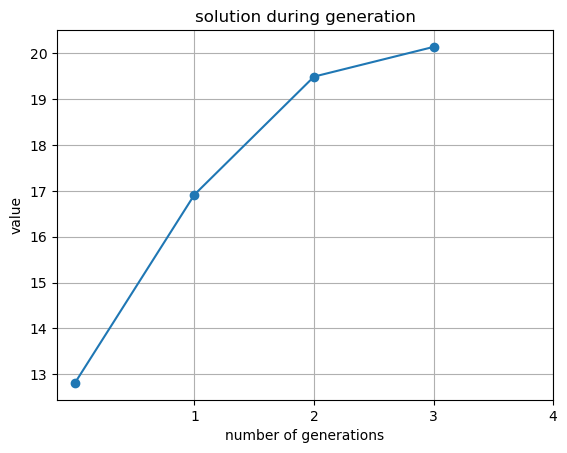

MazMaz: 2.5688073394495414
Jooj: 5.504587155963303
Hot-Dog: 1.926605504587156
Total Weight: 10.0
Total Value: 15.809305373525557


In [212]:

def solve_knapsack(positions, population):

    progress_indicator = []
    for i in range(NUMBER_OF_GENERATIONS):
        population = next_generation(population)
        progress_indicator.append(mid_fitness_of_gen(population))


    show_diagram(progress_indicator)
    population = sorted(population, key=lambda i: fitness(i))
    return population[0]


print_info(solve_knapsack(positions, population))

# Questions
## Q1
- if population is too small
  - - It's possible that effective and beneficial scenarios are overlooked.
  - - The algorithm may not have a good search space, and it may converge on a solution that may not necessarily be optimal
- if population is too big
  - - This leads to duplicate genes.
    - For terminating the algorithm, we may need to reduce the number of generations or design a more complex fitness function, which might not be easy.
## Q2
 - A generation with greater diversity and more exploration capability leads to better solutions. However, the algorithm may fail to converge.
## Q3
  - They both increase the variety and extent of genes, thus improving the search for the algorithm
  - mutation is used when we want to make a better children from two good parent from the previous generation and crossover is used to avoid getting stuck with specific genes.
  - It is possible to use either of them, but using them together leads to better solutions and results.
## Q4
- Transmitting good generations to the next ones.
- Well-designed and optimal fitness function.
- Initial population being good and reasonable along with meeting the conditions of the problem.
- Reasonablnd e agood reies for mutation, reproduction, and croserer.

## Q5
- The problem caused by this is that first, we cannot search and explore more within the population, and ultimately, we cannot find a good and optimal solution.
- incresing the mutation rate
- Using approaches like reproduction along with others
m

## Q6
- ### two approaches:
- - Setting a limit for the number of generations, as I have done.
- - Calculating the best (or even average) fitness of the generation and comparing it to the previous generation. If there is not much improvement terminating the algorithm